# Playing around with the Squeezenet
Hasn't generalized well yet. Could be because I haven't trained it much

In [1]:
import glob 
import cv2
import numpy as np
import skimage
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
cars = glob.glob("./data/image-data/vehicles/*/*.png")
non_cars = glob.glob("./data/image-data/non-vehicles/*/*.png")

In [74]:
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))])
X = []
for name in cars:    
    X.append(name)
for name in non_cars:    
    X.append(name)
X = np.array(X)

print(X.shape)

(17760,)


(14208,)
(256, 64, 64, 3) (256, 2)
[ 1.  0.]


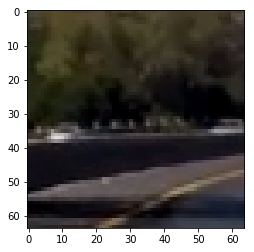

In [153]:
import random
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import LabelBinarizer

from keras import backend as K

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)
label_binarizer = LabelBinarizer()

def train_generator(batch_size=256, purpose='train'):
    data = None
    label = None
    if purpose == 'train':
        data = X_train
        label = Y_train
    else:
        data = X_test
        label = Y_test
    
    while 1:
        x_sample=[]
        y_sample=[]
        for i in range(batch_size):
            index = random.randint(0, data.shape[0]-1)
            x_sample.append(mpimg.imread(data[index]))
            y_sample.append(label[index])
        x = np.stack(x_sample)
        y = np.stack(y_sample)
#         y = label_binarizer.fit_transform(y)
        y = to_categorical(y, num_classes=None)
        yield x, y

print(X_train.shape)        
        
g = train_generator(purpose='test')
x, y = next(g)

# yy = K.eval(K.one_hot(y, 2))
# print(yy.shape)

print(x.shape, y.shape)

index = random.randint(0, 255)
print(y[index])
plt.imshow(x[index])

In [204]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Input, Concatenate
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.callbacks import LearningRateScheduler, Callback

def SqueezeNet(nb_classes, inputs=(64, 64, 3)):
    """ Keras Implementation of SqueezeNet(arXiv 1602.07360)
    @param nb_classes: total number of final categories
    Arguments:
    inputs -- shape of the input images (channel, cols, rows)
    """

    input_img = Input(shape=inputs)
    normalize = Lambda(lambda x: x - 0.5)(input_img)
    conv1 = Convolution2D(96, (7, 7), activation='relu', strides=(2, 2), padding='same', name='conv1')(normalize)
    maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool1',)(conv1)
    fire2_squeeze = Convolution2D(16, (1, 1), activation='relu', padding='same', name='fire2_squeeze')(maxpool1)
    fire2_expand1 = Convolution2D(64, (1, 1), activation='relu', padding='same', name='fire2_expand1')(fire2_squeeze)
    fire2_expand2 = Convolution2D(64, (3, 3), activation='relu', padding='same', name='fire2_expand2')(fire2_squeeze)
    merge2 = Concatenate(axis=3)([fire2_expand1, fire2_expand2])

    fire3_squeeze = Convolution2D(16, (1, 1), activation='relu', padding='same', name='fire3_squeeze')(merge2)
    fire3_expand1 = Convolution2D(64, (1, 1), activation='relu', padding='same', name='fire3_expand1')(fire3_squeeze)
    fire3_expand2 = Convolution2D(64, (3, 3), activation='relu', padding='same', name='fire3_expand2')(fire3_squeeze)
    merge3 = Concatenate(axis=3)([fire3_expand1, fire3_expand2])

    fire4_squeeze = Convolution2D(32, (1, 1), activation='relu', padding='same', name='fire4_squeeze')(merge3)
    fire4_expand1 = Convolution2D(128, (1, 1), activation='relu', padding='same', name='fire4_expand1')(fire4_squeeze)
    fire4_expand2 = Convolution2D(128, (3, 3), activation='relu', padding='same', name='fire4_expand2')(fire4_squeeze)
    merge4 = Concatenate(axis=3)([fire4_expand1, fire4_expand2])
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool4')(merge4)

    fire5_squeeze = Convolution2D(32, (1, 1), activation='relu', padding='same', name='fire5_squeeze')(maxpool4)
    fire5_expand1 = Convolution2D(128, (1, 1), activation='relu', padding='same', name='fire5_expand1')(fire5_squeeze)
    fire5_expand2 = Convolution2D(128, (3, 3), activation='relu', padding='same', name='fire5_expand2',)(fire5_squeeze)
    merge5 = Concatenate(axis=3)([fire5_expand1, fire5_expand2])

    fire6_squeeze = Convolution2D(48, (1, 1), activation='relu', padding='same', name='fire6_squeeze')(merge5)
    fire6_expand1 = Convolution2D(192, (1, 1), activation='relu', padding='same', name='fire6_expand1')(fire6_squeeze)
    fire6_expand2 = Convolution2D(192, (3, 3), activation='relu', padding='same', name='fire6_expand2')(fire6_squeeze)
    merge6 = Concatenate(axis=3)([fire6_expand1, fire6_expand2])

    fire7_squeeze = Convolution2D(48, (1, 1), activation='relu', padding='same', name='fire7_squeeze')(merge6)
    fire7_expand1 = Convolution2D(192, (1, 1), activation='relu', padding='same', name='fire7_expand1')(fire7_squeeze)
    fire7_expand2 = Convolution2D(192, (3, 3), activation='relu', padding='same', name='fire7_expand2')(fire7_squeeze)
    merge7 = Concatenate(axis=3)([fire7_expand1, fire7_expand2])

    fire8_squeeze = Convolution2D(64, (1, 1), activation='relu', padding='same', name='fire8_squeeze')(merge7)
    fire8_expand1 = Convolution2D(256, (1, 1), activation='relu', padding='same', name='fire8_expand1')(fire8_squeeze)
    fire8_expand2 = Convolution2D(256, (3, 3), activation='relu', padding='same', name='fire8_expand2')(fire8_squeeze)
    merge8 = Concatenate(axis=3)([fire8_expand1, fire8_expand2])

    maxpool8 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool8')(merge8)
    fire9_squeeze = Convolution2D(64, (1, 1), activation='relu', padding='same', name='fire9_squeeze')(maxpool8)
    fire9_expand1 = Convolution2D(256, (1, 1), activation='relu', padding='same', name='fire9_expand1')(fire9_squeeze)
    fire9_expand2 = Convolution2D(256, (3, 3), activation='relu', padding='same', name='fire9_expand2')(fire9_squeeze)
    merge9 = Concatenate(axis=3)([fire9_expand1, fire9_expand2])

#     fire9_dropout = Dropout(0.5, name='fire9_dropout')(merge9)
    conv10 = Convolution2D(nb_classes, (1, 1), padding='valid', name='conv10')(merge9)
    # The size should match the output of conv10
    avgpool10 = AveragePooling2D((3, 3), name='avgpool10')(conv10)

    flatten = Flatten(name='flatten')(avgpool10)
    softmax = Activation("softmax", name='softmax')(flatten)
    
    model = Model(inputs=input_img, outputs=softmax)
    sgd = SGD(lr=1e-1, decay=0.0002, momentum=0.9)
    adam = Adam(lr=1e-3, )
    model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

carIdModel = SqueezeNet(2)

# carIdModel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_68 (InputLayer)            (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
lambda_44 (Lambda)               (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 32, 32, 96)    14208                                        
____________________________________________________________________________________________________
maxpool1 (MaxPooling2D)          (None, 15, 15, 96)    0                                            
___________________________________________________________________________________________

In [205]:
# carIdModel.fit(X, Y, batch_size=256, epochs=20, verbose=2, validation_split=0.2, shuffle=True)
class SGDLearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        print('\nLearning Rate: {:.6f}\n'.format(lr))

generator_train = train_generator(purpose='train')
generator_validation = train_generator(purpose='train')
generator_test = train_generator(purpose='test')

carIdModel.fit_generator(generator_train, steps_per_epoch= 40, epochs=15, verbose=2, 
                         validation_data=generator_validation, validation_steps=10)

x, y = next(generator_test)
score = carIdModel.evaluate(x, y, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/15
8s - loss: 0.5308 - acc: 0.7127 - val_loss: 0.4086 - val_acc: 0.8090
Epoch 2/15
5s - loss: 0.3038 - acc: 0.8634 - val_loss: 0.2250 - val_acc: 0.9020
Epoch 3/15
5s - loss: 0.1741 - acc: 0.9254 - val_loss: 0.1777 - val_acc: 0.9223
Epoch 4/15
5s - loss: 0.1634 - acc: 0.9394 - val_loss: 0.1225 - val_acc: 0.9527
Epoch 5/15
5s - loss: 0.1094 - acc: 0.9605 - val_loss: 0.1142 - val_acc: 0.9633
Epoch 6/15
5s - loss: 0.1108 - acc: 0.9587 - val_loss: 0.0796 - val_acc: 0.9707
Epoch 7/15
5s - loss: 0.1086 - acc: 0.9597 - val_loss: 0.0855 - val_acc: 0.9668
Epoch 8/15
5s - loss: 0.0857 - acc: 0.9701 - val_loss: 0.0683 - val_acc: 0.9758
Epoch 9/15
5s - loss: 0.0623 - acc: 0.9792 - val_loss: 0.0638 - val_acc: 0.9789
Epoch 10/15
5s - loss: 0.0777 - acc: 0.9716 - val_loss: 0.0604 - val_acc: 0.9793
Epoch 11/15
6s - loss: 0.0572 - acc: 0.9794 - val_loss: 0.0683 - val_acc: 0.9750
Epoch 12/15
5s - loss: 0.0470 - acc: 0.9829 - val_loss: 0.0476 - val_acc: 0.9812
Epoch 13/15
5s - loss: 0.0713 - acc: 

In [74]:
carIdModel.save_weights("CarId_weights.h5", overwrite=True)
carIdModel.save("CarId_model.h5", overwrite=True)

# Only loading model from this point onward

In [6]:
import glob 
import cv2
import numpy as np
import skimage
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
%matplotlib inline

from car_id_model import CarIDModel
carIdModel = CarIDModel(loadweights=True)

# carIdModel.model.summary()

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 3.08 ms

index:51 actual:[ 1.  0.]
prediction: [[  9.99820054e-01   1.79969647e-04]]


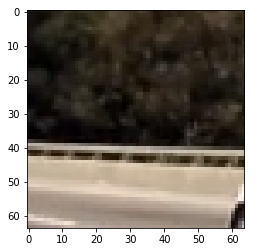

In [227]:
import random

generator_test = train_generator(batch_size=256, purpose='test')
x, y = next(generator_test)

index = random.randint(0, x.shape[0]-1)
plt.imshow(x[index])
# %time test = carIdModel.predictSingle(x[index])
%time test = carIdModel.predict(x[index][None, :, :, :])

print("")
print("index:{0} actual:{1}".format(index, y[index]))
print("prediction:", test)

[[ 47   0]
 [ 47   1]
 [ 92   0]
 [ 92   1]
 [ 93   0]
 [ 93   1]
 [127   0]
 [127   1]
 [145   0]
 [145   1]
 [183   0]
 [183   1]]
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.07 ms

index: 10  actual: [ 1.  0.]


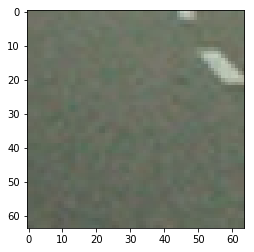

In [245]:
import pandas as pd

pred = carIdModel.predict(x)
pred = np.around(np.squeeze(pred), decimals=4)

diff = np.absolute(np.squeeze(y-pred))

incorrect = np.argwhere(diff>=0.4)
print(incorrect)

index = 10
plt.imshow(x[index])
%time test = carIdModel.predict(x[index][None, :, :, :])
print("")
# print("index:{0} actual:{1}".format(index, ",".join((str(x) for x in y[index]))))
print("index:", index, " actual:", y[index])
# print("prediction:", test)

resultpd = pd.DataFrame(y)
# resultpd["1"] = pred
# print(diff)

# plt.hist(diff)


In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy.ndimage.measurements import label
%matplotlib inline

In [247]:
df = pd.read_csv('./data/image-data/object-dataset/labels.csv', 
                 delim_whitespace=True,
                 names=["img", "xmin", "ymin", "xmax", "ymax", "occluded", "label", "attribute"]
                )
df["img"] = "./data/image-data/object-dataset/" + df["img"]
df.head()

,img,xmin,ymin,xmax,ymax,occluded,label,attribute
0,./data/image-data/object-dataset/1478019952686...,950,574,1004,620,0,car,NaN
1,./data/image-data/object-dataset/1478019952686...,1748,482,1818,744,0,pedestrian,NaN
2,./data/image-data/object-dataset/1478019953180...,872,586,926,632,0,car,NaN
3,./data/image-data/object-dataset/1478019953689...,686,566,728,618,1,truck,NaN
4,./data/image-data/object-dataset/1478019953689...,716,578,764,622,0,car,NaN


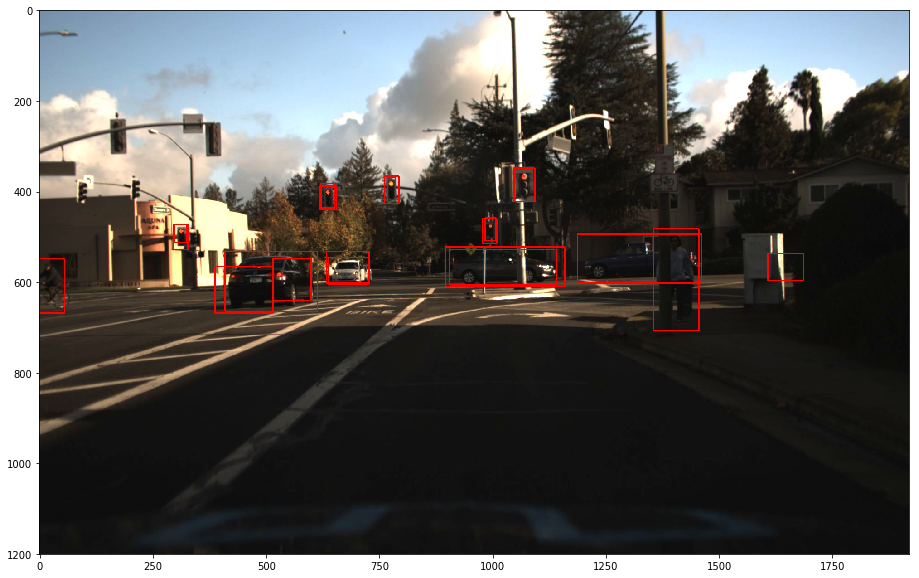

In [248]:
def get_boxes(img_path, df):
    boxes = []
    subset = df[df["img"] == img_path]
    for index, row in subset.iterrows():
        boxes.append(((row["xmin"], row["ymin"]), (row["xmax"], row["ymax"])))
    return boxes

def show_img(row, df): 
#     print(row["label"])
    img_path = row["img"]
    img = mpimg.imread(img_path)
    boxes = get_boxes(img_path, df)
    for box in boxes:
        img = cv2.rectangle(img, box[0], box[1], (255,0,0), 2)
    plt.figure(figsize=(20,10))
    plt.imshow(img)

# row = df.iloc[97]  #97 & 98
show_img(df.iloc[293], df)

In [249]:
dfcar = df[df["label"]=="car"].reset_index(drop=True)

dfcar.head()

,img,xmin,ymin,xmax,ymax,occluded,label,attribute
0,./data/image-data/object-dataset/1478019952686...,950,574,1004,620,0,car,NaN
1,./data/image-data/object-dataset/1478019953180...,872,586,926,632,0,car,NaN
2,./data/image-data/object-dataset/1478019953689...,716,578,764,622,0,car,NaN
3,./data/image-data/object-dataset/1478019953689...,826,580,880,626,0,car,NaN
4,./data/image-data/object-dataset/1478019953689...,1540,488,1680,608,1,car,NaN


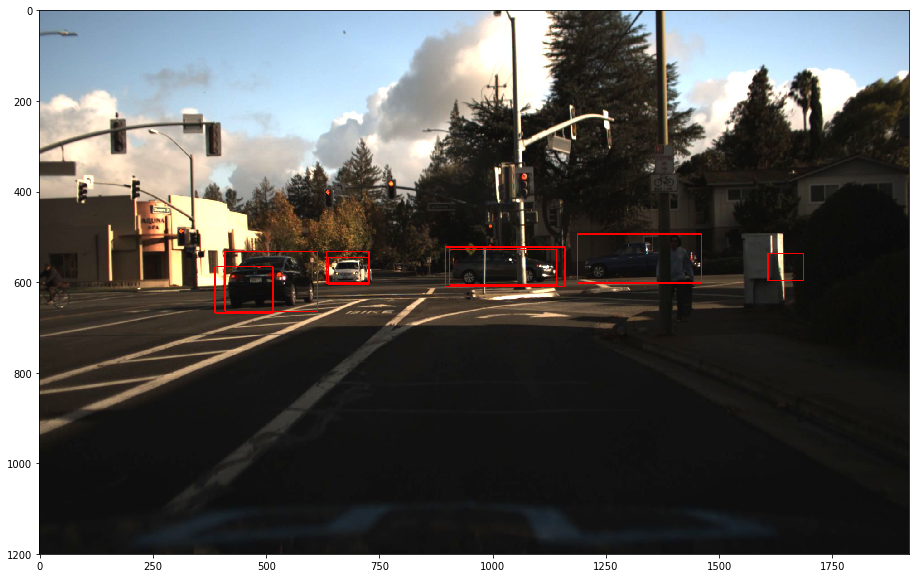

In [250]:
show_img(dfcar.iloc[171], dfcar)

(1200, 1920, 3)
[((462, 598), (606, 672)), ((468, 598), (592, 672))]


array([[ 0.00760649,  0.99239349]], dtype=float32)

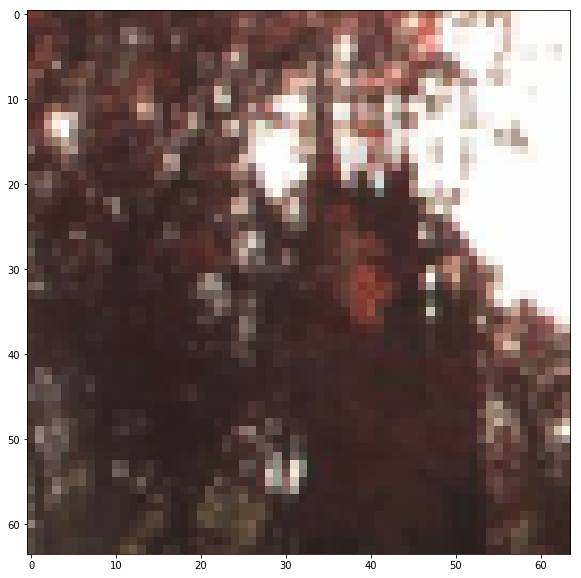

In [258]:
row = dfcar.iloc[328]
img_path= row["img"]
x = mpimg.imread(img_path)
x = x/255

boxes = get_boxes(img_path, dfcar)

print(x.shape)
print(boxes)
box = boxes[0]
# x = x[box[0][1]:box[1][1], box[0][0]:box[1][0], :]
x = x[320:520, 400:600, :]
x = cv2.resize(x, (64, 64), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(20,10))
plt.imshow(x)

carIdModel.predict(x[None, :, :, :])